In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

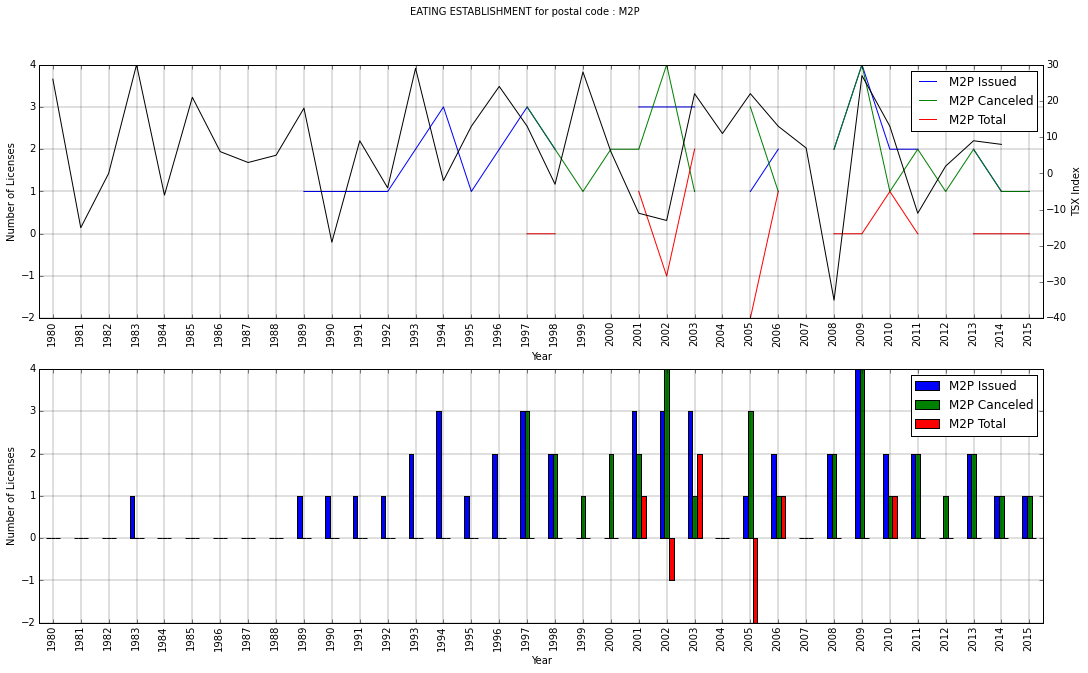

In [4]:
import pandas as pd
from pandas import DataFrame, Series
#adding graphics
import matplotlib.pyplot as plt
%pylab inline
from pylab import rcParams
from collections import defaultdict
from collections import OrderedDict as od
rcParams['figure.figsize'] = 18, 10
 
#from IPython.html import widgets
import ipywidgets as widgets
from IPython.display import display
 
#import gmaps
 
###################################
 
all_lic = pd.read_table('ready_data.csv', sep=',')
tsxdata = pd.read_csv("tsx.csv")
#this will get the tsx data
def getgain(year):
    row=tsxdata[tsxdata['year']==year]
    if len(row.index) >0 :
        return row.iloc[0]['gain']
    else :
        return np.nan
 
#fix the dates
def addyear(x):
    if x is nan :
        return nan
    ystr = x[6]+x[7]
    if (ystr>'18') :
        ystr = '19'+ystr
    else :
        ystr = '20'+ystr
    return ystr
 
def getarea(po) :
    area = po[:3]
    return area
# get rid of nulls in postal codes
all_lic= all_lic[pd.notnull(all_lic['Licence Address Line 3'])]
all_lic['year_issued']=all_lic["Issued"].map(addyear)
all_lic['year_cancel']=all_lic["Cancel Date"].map(addyear)
 
 
all_lic['area']=all_lic['postal'].map(getarea)
 
cat = all_lic['Category']
d = defaultdict(int)
for c in cat :  
    d[c]+=1
df = DataFrame(d.items(),columns=['category','count'])
indf = df.set_index(['category'])
indf=indf.sort_index()
#####################################
def limit_year(dataset,yearfield,start=None,end=None,year=None) :
    target = dataset
    if (start is not None):
        target= target [target[yearfield]>= start]
    if (end is not None) :
        target = target[target[yearfield]<= end]
    if (year is not None) :
        target = target[target[yearfield]== year]
    return target
 
# here we build the weights of each area
def getweighted(dataset) :
    target = dataset
    areadict = defaultdict(int)
    for c in dataset['area'] :  
        areadict[c]+=1
    f = lambda x : areadict[x]
    target['w'] = target['area'].map(f)
    return target
 
# function gets total of a category through years in a single dataset
def get_totals_by(dataset,cat) :
    d = defaultdict(int)
    catseries=dataset[cat]
    for c in catseries :  
        if c is not nan :
            d[c]+=1
    df = DataFrame(d.items(),columns=[cat,'count'])
    indf = df.set_index([cat])
    indf= indf.sort_index()
    return indf
 
#this function will take totals and make sure that if there is any missing years in the series
# the years will have 'nan' it and be inserted in the 'target ' data frame
def spread_totals_by_years(totals,starty,endy):
    myindex = range (starty,endy+1)
    strindex = map(str, myindex)
    mydf = pd.DataFrame(index=strindex)
    targetpdf = pd.concat([mydf,totals],axis=1)
    return targetpdf
 
 
def limit_by_area (dataset,area) :
    target = dataset[dataset['area']==area]
    return target
 
def get_category(cat):
    cat_target= all_lic [all_lic['Category']==cat]
    return cat_target
################################################
year_rest = limit_year(get_category(cat='EATING ESTABLISHMENT'),year='2012',yearfield='year_issued')
 
 
year_w = getweighted(year_rest)
 
#ignore errors
year_w=year_w[year_w['lat']!=0]
 
year_w_heatdata= year_w[['lat','lng','w']]
heatmapdata= year_w_heatdata.to_records(index=False)
 
# Time to put an interface on this
def yearly_graph(category,starty,endy,postal,postal2,plot_i,plot_c,plot_t,plot_tsx,printme,saveme):  
    # first get the Year Issued  range
    if len(postal)!=3 :
        print " Postal Code ", postal, " is invalid, Enter only first 3 letters of the postal code "
        return
    if postal2!="NONE" and len (postal2) != 3:
        print " Second Postal Code ", postal2, " is invalid, Enter only first 3 letters of the postal code "
        return
    postal=postal.upper()
    if postal=="ALL" :
        issued_dataset = limit_year(get_category(cat=category),start=str(starty),end=str(endy),yearfield="year_issued")
        cancel_dataset = limit_year(get_category(cat=category),start=str(starty),end=str(endy),yearfield="year_cancel")
    else :
        issued_dataset = limit_by_area(limit_year(get_category(cat=category),yearfield="year_issued",start=str(starty),end=str(endy)),postal)
        cancel_dataset = limit_by_area(limit_year(get_category(cat=category),yearfield="year_cancel",start=str(starty),end=str(endy)),postal)
    #
    if postal2!="NONE" :
        postal2=postal2.upper()
        issued2_dataset = limit_by_area(limit_year(get_category(cat=category),yearfield="year_issued",start=str(starty),end=str(endy)),postal2)
        cancel2_dataset = limit_by_area(limit_year(get_category(cat=category),yearfield="year_cancel",start=str(starty),end=str(endy)),postal2)
 
    
    # set column names
    icol1 = postal + " Issued"
    ccol1 = postal + " Canceled"
    tcol1 = postal + " Total"
    icol2 = postal2 + " Issued"
    ccol2 = postal2 + " Canceled"
    tcol2 = postal2 + " Total"
    
    # Build Serieses of Data to be ready for display
    finalissued = get_totals_by(issued_dataset,'year_issued')
    finalissued.rename(columns={'count':icol1}, inplace=True)
    finalissued = spread_totals_by_years(finalissued,starty,endy)
    finalcanceled= get_totals_by(cancel_dataset,'year_cancel')
    finalcanceled.rename(columns={'count':ccol1}, inplace=True)
    finalcanceled = spread_totals_by_years(finalcanceled,starty,endy)
    finaltotal=pd.DataFrame(index=finalissued.index)
    finaltotal[tcol1]= finalissued[icol1]-finalcanceled[ccol1]
   
    if postal2!="NONE" :
        finalissued2 = get_totals_by(issued2_dataset,'year_issued')
        finalissued2.rename(columns={'count':icol2}, inplace=True)
        finalissued2 = spread_totals_by_years(finalissued2,starty,endy)
 
        finalcanceled2= get_totals_by(cancel2_dataset,'year_cancel')
        finalcanceled2.rename(columns={'count':ccol2}, inplace=True)
        finalcanceled2 = spread_totals_by_years(finalcanceled2,starty,endy)
 
        if len (finalissued2.index)!=0 :
            finaltotal2=pd.DataFrame(index=finalissued2.index)
            finaltotal2[tcol2]= finalissued2[icol2]-finalcanceled2[ccol2]
    
    final = pd.DataFrame(index=finaltotal.index)
    if plot_i :
        final = pd.concat ([final,finalissued],axis=1)
        if postal2!="NONE" :
            final = pd.concat ([final,finalissued2],axis=1)
    if plot_c :
        final = pd.concat ([final,finalcanceled],axis=1)
        if postal2!="NONE" :
            final = pd.concat ([final,finalcanceled2],axis=1)
    if plot_t :
        final = pd.concat ([final,finaltotal],axis=1)
        if (postal2!="NONE") and (len (finalissued2.index)!=0 ) :
            final = pd.concat ([final,finaltotal2],axis=1)
   
    if plot_tsx :
        tsxyears = limit_year(tsxdata,start=starty,end=endy,yearfield='year')
        tsxyears [['year']] = tsxyears[['year']].astype(str)
        tsxyears=tsxyears.set_index('year')
        final =pd.concat([final,tsxyears],axis=1)
 
    if len(final.index)==0 :
        print "There is no data in the current selection"
        plt.clf()
        return
    else :
        mycolors = ['green','red','blue']
        fig=plt.figure()
        linesplt=fig.add_subplot(2,1,1)
#        somevar, axarr = plt.subplots(2, sharex=True)
#        plt.subplots_adjust(hspace = .2 )
#        linesplt=axarr[0]
        linesplt.grid('on', which='major', axis='x' )
        linesplt.grid('on', which='major', axis='y' )
#        lplt =final.plot(ax=linesplt,color=mycolors)
        justlicenses = final
        if plot_tsx :
             justlicenses = final.drop(['gain', 'first','last'], axis=1) # drop this data
        lplt =justlicenses.plot(ax=linesplt,x=final.index)
        lplt.xaxis.grid(True, which='major', linestyle='-', linewidth=0.25)
        lplt.yaxis.grid(True, which='major', linestyle='-', linewidth=0.25)
        lplt.set_xlabel("Year")
        lplt.set_ylabel("Number of Licenses")
        lplt.set_xticks(range(0,endy-starty+1))
        lplt.set_xticklabels(final.index,rotation=90)
        if plot_tsx :
            ax2 = linesplt.twinx() # Create another axes that shares the same x-axis as ax.
            ax2.set_ylabel("TSX Index")
            final['gain'].plot(ax=ax2,color='black',x=final.index)
            
#        barsplt=axarr[1]
        barsplt=fig.add_subplot(2,1,2,sharex=lplt)
#        barsplt.xaxis.tick_top()
#        bplt=final.plot(ax=barsplt, kind='bar',color=mycolors)
        bplt=justlicenses.plot(ax=barsplt, kind='bar')
        bplt.xaxis.grid(True, which='major', linestyle='-', linewidth=0.25)
        bplt.yaxis.grid(True, which='major', linestyle='-', linewidth=0.25)
        bplt.set_xlabel("Year")
        bplt.set_ylabel("Number of Licenses")
        bplt.set_xticks(range(0,endy-starty+1))
        bplt.set_xticklabels(final.index,rotation=90)
        title = category+" for postal code : "+ postal
        if postal2!="NONE" :
            title=title+ " compared to postal code " + postal2
        plt.suptitle(title )
#        plt.show()  
        weighted_issued = getweighted(issued_dataset)
        year_w_heatdata= weighted_issued[['lat','lng','w']]
        heatmapdata= year_w_heatdata.to_records(index=False)
#        m = gmaps.heatmap(heatmapdata, max_intensity=10, point_radius=4)
#        gmaps.display(m)
    if (printme) :
        print tcol1,final[tcol1].sum()
        if postal2!="NONE" :
            print tcol2,final[tcol2].sum()
        print " final data"
        print final
        print issued_dataset
        print cancel_dataset
    if (saveme) :
        fig.savefig(category+"_"+postal+"_"+str(starty)+"_"+str(endy)+".png")
#    return fig
       
catlist_w = widgets.Select()
catlist_w.options = list( indf.index)
catlist_w.label =" Category "
yearrange= range(1980,2016)
stryearrange =[str(i) for i in yearrange]
 
startyear_w = widgets.IntSlider(value=1980,min=1919,max=2015,step=1,description='Start YEAR !')
endyear_w = widgets.IntSlider(value=2015,min=1919,max=2015,step=1,description='End YEAR !')
 
postalfield = widgets.Text()
postalfield.description = "Postal Code"
postalfield.value ="ALL"
postalfield2 = widgets.Text()
postalfield2.description = "Second Postal (Optaional)"
postalfield2.value ="NONE"
 
 
plot_i_w = widgets.Checkbox(
    description='Plot Issued',
    value=True
)
 
plot_c_w = widgets.Checkbox(
    description='Plot Canceled',
    value=True
)
 
plot_t_w = widgets.Checkbox(
    description='Plot Total',
    value=True
)
 
plot_tsx_w = widgets.Checkbox(
    description='Plot TSX Returns',
    value=True
)
 
print_data_w = widgets.Checkbox(
    description='Print Data',
    value=False
)
 
save_image_w = widgets.ToggleButton(
    description='Save as png',
    value=False
)
start_range = widgets.IntSlider(min=1980,max=2015,step=1,description='Start YEAR !')
wid=widgets.interact( yearly_graph,
                 category    = catlist_w,
                 starty  = startyear_w,
                 endy = endyear_w,
                 postal = postalfield,
                 postal2 = postalfield2,
                 plot_i = plot_i_w,
                 plot_c = plot_c_w,
                 plot_t = plot_t_w,
                 plot_tsx = plot_tsx_w,
                 printme = print_data_w,
                 saveme = save_image_w
             )